In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw
# from netgen import gui
from ngsolve.comp import ConvertOperator
import numpy as np

import time

Geometrie: Spule mit Luftspalt und Stahlplatte dazwischen

In [2]:
geo = CSGeometry()
box_size = 2
box = OrthoBrick(Pnt(-box_size,-box_size,-box_size), Pnt(box_size,box_size,box_size)).bc("outer")

lx = 0.4
lz = 0.5
d = 0.1
lp = 0.3
core = OrthoBrick(Pnt(-lx,-d/2,-lz),Pnt(lx,d/2,lz))- \
           OrthoBrick(Pnt(d-lx,-d,-lz+d),Pnt(lx-d,d,lz-d))- \
           OrthoBrick(Pnt(d,-d,-d/2),Pnt(lx+d,d,d/2)).maxh(0.2).mat("core")

plate = OrthoBrick(Pnt(d/2,-lp,-d/4),Pnt(2*lx-d,lp,d/4)).mat('plate')


coil = (Cylinder(Pnt(-lx+d/2,0,0), Pnt(-lx+d/2,0,1), 3*d) - \
        Cylinder(Pnt(-lx+d/2,0,0), Pnt(-lx+d/2,0,1), d)) * \
        OrthoBrick (Pnt(-1,-1,-lz+2*d),Pnt(1,1,lz-2*d)).maxh(0.2).mat('coil')

air = (box - coil - plate -core).mat('air') 

geo.Add(plate)
geo.Add(core)
geo.Add(coil)
geo.Add(air, transparent=True)

mesh = Mesh(geo.GenerateMesh(maxh=0.5))
mesh.Curve(1)
Draw (mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 1, 'order3d': 1…

$$
\DeclareMathOperator{\Grad}{grad}
\DeclareMathOperator{\Curl}{curl}
\DeclareMathOperator{\Div}{div}
\DeclareMathOperator{\R}{\mathbb{R}}
\DeclareMathOperator{\real}{real}
\DeclareMathOperator{\reg}{reg}
$$
### Magnetostatisches Problem ohne Stahlplatte

Finde $ u \in H(\Curl)$ sodass 
$$
\int \mu^{-1} \Curl u \Curl v + \reg \int  u  v= \int j v \qquad  \forall \, v \in H(\Curl) \tag{1}
$$

Wir nehmen zunächst an, dass der `core` aus einem tollen Material besteht das immer eine hohe, lineare Permeabilität hat. Um in den nichtlinearen Bereich des Stahls zu kommen wollen wir ein Magnetfeld zwischen 1.0 und 1.5 Tesla im Lufspalt. 

In folgender Rechnung wird vernachlässigt, dass der Luftspalt (bzw dann die zwei Luftspalte) kleiner ist wenn sich eine Stahlplatte darin befindet, daher ist das Ziel ohne Stahlplatte auf ca 1T zu kommen. Außerdem wird angenommen dass es keine Streuflüsse gibt. 

Es gilt für das Magnetfeld im Luftspalt $B_l$ gilt $B = \frac{\Phi}{A}$ Wobei $\Phi$ die magnetische Flussdichte und $A$ die Querschnittsfläche des Luftspalts ist. Die von der Spule erzeugte Durchflutung $\Theta$ beträgt $4d(l_z-d)*j$, falls die Stromdichte $j$ konstant ist.  Wenn wir die im Kern abfallende magnetische Spannung vernachlässigen gilt wegen $\Theta = R\Phi$ und des magnetische Widerstands im Luftspalt $R = \frac{d}{\mu_0A}$ dass    

$$ 
4d(l_z-d)j = \Theta = \frac{d}{\mu_0A}\Phi = \frac{d}{\mu_0}B.
$$

Die Stromdichte ergibt sich also ungefähr als 
$$
 j \approx \frac{B}{4\mu_0(l_z-d) } \approx 5*10^5.
$$

Es stellt sich heraus, dass $j \approx 7*10^5$ zum gewünschten einen Tesla führt. 

In [ ]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u,v = fes.TnT()
from math import pi

j = 7*1e5
mu0 = 4*pi*1e-7
mur = { "core" : 1e10, "coil" : 1, "air" : 1, "plate": 1}
nu = CoefficientFunction([1/(mu0*mur[mat]) for mat in mesh.GetMaterials()]) # max: 10^2, min:10^6 
reg = 1e-6*nu

a = BilinearForm(fes)
a += nu*curl(u)*curl(v)*dx + reg*u*v*dx
c = Preconditioner(a, "bddc")

f = LinearForm(fes)
f += CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(1/sqrt(y**2+(lx-d/2+x)**2))*j*v*dx(mesh.Materials('coil'))

gfu = GridFunction(fes)
# Was passiert wenn blf schon linear ist?
# test = gfu.vec.CreateVector()
# test[:] = 0

with TaskManager():
    a.Assemble()
#     a.AssembleLinearization(test)
    f.Assemble()
    solvers.CG(sol=gfu.vec, rhs=f.vec, mat=a.mat, pre=c.mat)


# a.AssembleLinearization(gfu.vec)
# solvers.CG(sol=gfu.vec, rhs=f.vec, mat=a.mat, pre=c.mat)
def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    Draw (nu*curl(gfu), mesh, "H-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))
# Draw(CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(1/sqrt(y**2+(lx-d/2+x)**2)), mesh)
show()

### Magnetostatisches Problem mit Stahlplatte

Ohne dem Regularisierungsterm lautet das nichtlineare Problem:


Finde $ u \in H(\Curl)$ sodass 
$$
\int \underbrace{\frac{1}{\mu(|B|)}\Curl u}_{=H} \Curl v = \int j v \qquad  \forall \, v \in H(\Curl) \tag{2}
$$

Wenn $u$ das Mimimierungsproblem 
$$
F(u) := \int \omega(|\Curl u|) - \int ju  \qquad \min !
$$
mit 
$$
w(x) = \int_0^{x} \frac{1}{\mu(s)}s ~ ds
$$
löst, dann erfüllt $u$ auch (1). 


Um das einzusehen berechne die erste Variation von $F$:
$$
\begin{split}
\lim_{\epsilon \rightarrow 0} \frac{d}{d\epsilon} F(u+\epsilon v) &= \int \lim_{\epsilon \rightarrow 0}\frac{1}{\mu(|\Curl(u+\epsilon v)|)}|\Curl(u+\epsilon v)|\frac{\Curl(u+\epsilon v)}{|\Curl(u+\epsilon v)|}\Curl v  - \int jv\\
&= \int \frac{1}{\mu(|\Curl u|)}\Curl u \Curl v  - \int jv
\end{split}
$$

Die folgende H-B Kurve ist aus der TEAM 13 Lösung von Valentin Hanser:

Text(0, 0.5, 'Magnetic Flux Density B in T')

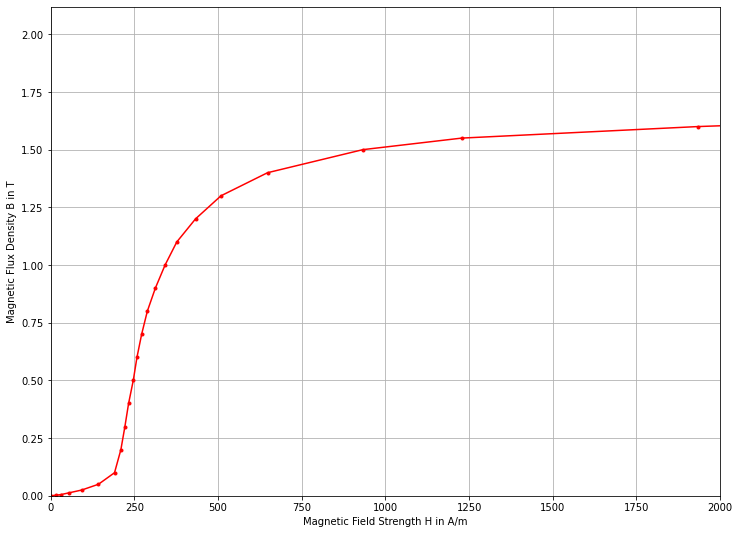

In [3]:
from matplotlib import pyplot as plt

H_KL = [ -4.47197834e-13, 1.60000000e+01, 3.00000000e+01, 5.40000000e+01\
, 9.30000000e+01, 1.43000000e+02, 1.91000000e+02, 2.10000000e+02 \
, 2.22000000e+02, 2.33000000e+02, 2.47000000e+02, 2.58000000e+02\
, 2.72000000e+02, 2.89000000e+02, 3.13000000e+02, 3.42000000e+02\
, 3.77000000e+02, 4.33000000e+02, 5.09000000e+02, 6.48000000e+02\
, 9.33000000e+02, 1.22800000e+03, 1.93400000e+03, 2.91300000e+03\
, 4.99300000e+03, 7.18900000e+03, 9.42300000e+03, 9.42300000e+03\
, 1.28203768e+04, 1.65447489e+04, 2.07163957e+04, 2.55500961e+04\
, 3.15206135e+04, 4.03204637e+04, 7.73038295e+04, 1.29272791e+05\
, 1.81241752e+05, 2.33210713e+05, 2.85179674e+05, 3.37148635e+05\
, 3.89117596e+05, 4.41086557e+05, 4.93055518e+05, 5.45024479e+05\
, 5.96993440e+05, 6.48962401e+05, 7.00931362e+05, 7.52900323e+05\
, 8.04869284e+05, 8.56838245e+05, 9.08807206e+05, 9.60776167e+05\
, 1.01274513e+06, 1.06471409e+06, 1.11668305e+06, 1.16865201e+06\
, 1.22062097e+06, 1.27258993e+06, 1.32455889e+06, 1.37652785e+06\
, 1.42849682e+06, 1.48046578e+06, 1.53243474e+06, 1.58440370e+06\
, 1.63637266e+06, 1.68834162e+06, 1.74031058e+06, 1.79227954e+06\
, 1.84424850e+06, 1.89621746e+06, 1.94818643e+06, 2.00015539e+06\
, 2.05212435e+06, 2.10409331e+06, 2.15606227e+06, 2.20803123e+06\
, 2.26000019e+06]

B_KL = [ 0.00000000e+00, 2.50000000e-03, 5.00000000e-03, 1.25000000e-02\
, 2.50000000e-02, 5.00000000e-02, 1.00000000e-01, 2.00000000e-01\
, 3.00000000e-01, 4.00000000e-01, 5.00000000e-01, 6.00000000e-01\
, 7.00000000e-01, 8.00000000e-01, 9.00000000e-01, 1.00000000e+00\
, 1.10000000e+00, 1.20000000e+00, 1.30000000e+00, 1.40000000e+00\
, 1.50000000e+00, 1.55000000e+00, 1.60000000e+00, 1.65000000e+00\
, 1.70000000e+00, 1.75000000e+00, 1.80000000e+00, 1.80000000e+00\
, 1.86530612e+00, 1.93061224e+00, 1.99591837e+00, 2.06122449e+00\
, 2.12653061e+00, 2.19183673e+00, 2.25714286e+00, 2.32244898e+00\
, 2.38775510e+00, 2.45306122e+00, 2.51836735e+00, 2.58367347e+00\
, 2.64897959e+00, 2.71428571e+00, 2.77959184e+00, 2.84489796e+00\
, 2.91020408e+00, 2.97551020e+00, 3.04081633e+00, 3.10612245e+00\
, 3.17142857e+00, 3.23673469e+00, 3.30204082e+00, 3.36734694e+00\
, 3.43265306e+00, 3.49795918e+00, 3.56326531e+00, 3.62857143e+00\
, 3.69387755e+00, 3.75918367e+00, 3.82448980e+00, 3.88979592e+00\
, 3.95510204e+00, 4.02040816e+00, 4.08571429e+00, 4.15102041e+00\
, 4.21632653e+00, 4.28163265e+00, 4.34693878e+00, 4.41224490e+00\
, 4.47755102e+00, 4.54285714e+00, 4.60816327e+00, 4.67346939e+00\
, 4.73877551e+00, 4.80408163e+00, 4.86938776e+00, 4.93469388e+00\
, 5.00000000e+00]
bh_curve = BSpline (2, [0]+list(B_KL), list(H_KL)) # [0] + is needed!
energy_dens = bh_curve.Integrate()
# help(energy_dens.Integrate())


plt.figure(1, figsize=[12, 9])
plt.clf()
plt.plot(H_KL, B_KL, '.-r')
plt.xlim(0, 2000)
plt.ylim(0, 2.12)
plt.grid()
plt.xlabel("Magnetic Field Strength H in A/m")
plt.ylabel("Magnetic Flux Density B in T")

### Implementierung ähnlich wie im Beipiel

In dem Beipiel wird die schwache Formulierung mit dem Minimierungsproblem gemischt. Gibt es dafür einen Grund?

In [13]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u,v = fes.TnT()
from math import pi

j = CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(-1/sqrt(y**2+(lx-d/2+x)**2)*7*1e3)
mu0 = 4*pi*1e-7
mur = { "core" : 1e8, "coil" : 1, "air" : 1}

a = BilinearForm(fes)
for mat in mur.keys():
    a += 1/(mu0*mur[mat])*curl(u)*curl(v)*dx(mat) + 1e-6*1/(mu0*mur[mat])*u*v*dx(mat)
a += SymbolicEnergy(energy_dens(sqrt(1e-12+ curl(u)*curl(u))), definedon = 'plate') 
a += 1e-3*u*v*dx('plate')
    
## TODO: hier preconditioning Beispiel
c = Preconditioner(a, "bddc")

f = LinearForm(fes)
f += j*v*dx(mesh.Materials('coil'))


TOL = 1e-10
MAX_IT = 60

with TaskManager():

    f.Assemble()

    gfu = GridFunction(fes)
    gfu_plot1 = GridFunction(fes)
    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
    gfu.vec[:] = 0

    err = 1
    it = 0
    
    while err > TOL and it < MAX_IT:
        it += 1
        
        e_old = a.Energy(gfu.vec) - InnerProduct(f.vec, gfu.vec)
        
        a.Apply(gfu.vec, tmp)
        res.data = tmp - f.vec
        
        a.AssembleLinearization(gfu.vec)
        solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat)
        
        err = abs(InnerProduct(w, res))
        
        print("\n error {} in iteration {}".format(err, it))
        
        tmp.data = gfu.vec - w
        
        e_new = a.Energy(tmp) - InnerProduct(f.vec, tmp)
        print("old energy: {}, new energy: {}".format(e_old, e_new))
        
        tau = 1
        cnt = 1
        while e_new > e_old:
            tau *= max(0.1, 1-0.1*cnt)
            cnt += 1
            tmp.data = gfu.vec - tau*w
            e_new = a.Energy(tmp) - InnerProduct(f.vec, tmp)
            print("new energy: {} with tau: {}".format( e_new, tau))
        
        gfu.vec.data = tmp
    
    gfu_plot1.vec.data = gfu.vec


def show1():
    Draw (curl(gfu_plot1), mesh, "B-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu_plot1)(mip), np.linalg.norm(curl(gfu_plot1)(mip)))

iteration 0 error = 5.830604184019357
iteration 1 error = 3.787866329577403
iteration 2 error = 3.4016548321574867
iteration 3 error = 1.9318785466720643
iteration 4 error = 1.2461790697517645
iteration 5 error = 0.6773200642915077
iteration 6 error = 0.47495641716970116
iteration 7 error = 0.30330880215794864
iteration 8 error = 0.19327261028624623
iteration 9 error = 0.1250903754311436
iteration 10 error = 0.08674508155007006
iteration 11 error = 0.0673823114405719
iteration 12 error = 0.05146065894109938
iteration 13 error = 0.03339682297744126
iteration 14 error = 0.021739703604297066
iteration 15 error = 0.016210808369913177
iteration 16 error = 0.012270610791082789
iteration 17 error = 0.008027153164235874
iteration 18 error = 0.0066894763446153065
iteration 19 error = 0.004837103982927107
iteration 20 error = 0.0033939661713825752
iteration 21 error = 0.002675334656590382
iteration 22 error = 0.0019055773115366997
iteration 23 error = 0.0012651382833191744
iteration 24 error = 0

iteration 22 error = 0.00014898106341027306
iteration 23 error = 0.00013891041044901105
iteration 24 error = 9.343316962030327e-05
iteration 25 error = 6.322674588693053e-05
iteration 26 error = 4.264154440076374e-05
iteration 27 error = 2.9442816155891402e-05
iteration 28 error = 2.031173690648299e-05
iteration 29 error = 1.460714912875225e-05
iteration 30 error = 1.0997037100028173e-05
iteration 31 error = 7.620809130207239e-06
iteration 32 error = 5.002222305653622e-06
iteration 33 error = 3.853846017584772e-06
iteration 34 error = 2.5535985344332793e-06
iteration 35 error = 1.8874110841155032e-06
iteration 36 error = 1.2225790491846226e-06
iteration 37 error = 8.938032648935898e-07
iteration 38 error = 5.958796472475753e-07
iteration 39 error = 4.044933707276277e-07
iteration 40 error = 2.7018407539377647e-07
iteration 41 error = 2.0210730225599314e-07
iteration 42 error = 1.490787623561441e-07
iteration 43 error = 9.797418235252213e-08
iteration 44 error = 7.021572188645675e-08
it

iteration 41 error = 2.95107798370501e-10
iteration 42 error = 2.1495789360440406e-10
iteration 43 error = 1.5739606291044056e-10
iteration 44 error = 9.287524673482476e-11
iteration 45 error = 6.598210839706147e-11
iteration 46 error = 4.8444489675279675e-11
iteration 47 error = 3.150098635390941e-11
iteration 48 error = 2.7749960394647406e-11
iteration 49 error = 2.0371870840229668e-11
iteration 50 error = 1.3511712914764354e-11
iteration 51 error = 1.0291223554651087e-11
iteration 52 error = 8.542918805387224e-12
iteration 53 error = 5.859211843797986e-12
iteration 54 error = 3.7629875167115615e-12
iteration 55 error = 3.7698566715211675e-12
iteration 56 error = 2.2075232805506353e-12
iteration 57 error = 1.619440228740847e-12
iteration 58 error = 1.14739912548409e-12
iteration 59 error = 8.545931024635767e-13
iteration 60 error = 6.607835484231603e-13
iteration 61 error = 4.4844766581130066e-13
iteration 62 error = 4.0076612122799795e-13
iteration 63 error = 2.581067441134487e-13
i

In [14]:
show1()

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

(8.831362322594824e-07, 7.246259089734905e-05, 0.009022913230260656) 0.009023204240613307


### Ganz als Minimierungsproblem

Minimiere das Funktional 

$$
F(u) := \int_{\text{plate}} \omega(|\Curl u|) + \int_{\Omega\setminus\text{plate}} \frac{1}{2\mu}\Curl u^2 + \reg \int \frac{1}{2} u^2  - \int ju  \tag{3}
$$

Funktioniert viel besser, unterscheidet sich aber in den Ergebnissen von obiger Version, warum?

Beide Versionen sind Abhäbngig von den Startwerten obwohl die Funktionale konvex sind (gibt es eine schnelle Möglichkeit BSplines zu plotten?). Warum? 

In [18]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u = fes.TrialFunction()
from math import pi

j = CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(-1/sqrt(y**2+(lx-d/2+x)**2)*7*1e3)
mu0 = 4*pi*1e-7
mur = { "core" : 1e8, "coil" : 1, "air" : 1}

a = BilinearForm(fes)
for mat in mur.keys():
    a += Variation( 1/(2*mu0*mur[mat])*curl(u)*curl(u)*dx(mat) + 1e-6*1/(2*mu0*mur[mat])*u*u*dx(mat))
a += Variation(energy_dens(sqrt(1e-12+ curl(u)*curl(u))) * dx('plate')) # 1e-12+ ?
a += Variation(1e-3/2*u*u*dx('plate') )
a += Variation(j*u*dx('coil'))
    
## TODO: hier preconditioning Beispiel
c = Preconditioner(a, "bddc")

TOL = 1e-10
MAX_IT = 60

with TaskManager():

    gfu = GridFunction(fes)
    gfu_plot2 = GridFunction(fes)
    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
    gfu.vec[:] = 0

    err = 1
    it = 0
    
    while err > TOL and it < MAX_IT:
        it += 1
        
        e_old = a.Energy(gfu.vec)
        
        a.Apply(gfu.vec, res)
        
        a.AssembleLinearization(gfu.vec)
        solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat)
        
        err = abs(InnerProduct(w, res))
        
        print("\n error {} in iteration {}".format(err, it))
        
        tmp.data = gfu.vec - w
        
        e_new = a.Energy(tmp)
        print("old energy: {}, new energy: {}".format(e_old, e_new))
        
        tau = 1
        cnt = 1
        while e_new > e_old:
            tau *= max(0.1, 1-0.1*cnt)
            cnt += 1
            tmp.data = gfu.vec - tau*w
            e_new = a.Energy(tmp)
            print("new energy: {} with tau: {}".format( e_new, tau))
            
        gfu.vec.data = tmp
        
        
    gfu_plot2.vec.data = gfu.vec


def show2():
    Draw (curl(gfu_plot2), mesh, "B-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu_plot2)(mip), np.linalg.norm(curl(gfu_plot2)(mip)))

iteration 0 error = 6.091648975213895
iteration 1 error = 5.761783175480131
iteration 2 error = 5.8456090331867046
iteration 3 error = 3.6096038733702693
iteration 4 error = 2.3728049396513096
iteration 5 error = 1.379030737648399
iteration 6 error = 0.8807674793242483
iteration 7 error = 0.615787117251981
iteration 8 error = 0.40973499078498954
iteration 9 error = 0.25770574403690477
iteration 10 error = 0.1637053402232442
iteration 11 error = 0.1158979082901481
iteration 12 error = 0.09768187402064443
iteration 13 error = 0.06414351742936333
iteration 14 error = 0.04109147533842125
iteration 15 error = 0.037152725532663654
iteration 16 error = 0.02339846855914257
iteration 17 error = 0.015182525662834265
iteration 18 error = 0.01151840946733124
iteration 19 error = 0.007910513949023184
iteration 20 error = 0.006451617990652639
iteration 21 error = 0.004629582960876176
iteration 22 error = 0.0034057901574603717
iteration 23 error = 0.002198587192719299
iteration 24 error = 0.001557668

iteration 25 error = 1.8685732294808464e-08
iteration 26 error = 1.3888993329838386e-08
iteration 27 error = 1.025351279338408e-08
iteration 28 error = 7.185695937980026e-09
iteration 29 error = 4.385818247937731e-09
iteration 30 error = 3.042271463316023e-09
iteration 31 error = 2.5921732352525306e-09
iteration 32 error = 1.6688279709491542e-09
iteration 33 error = 1.125909823024272e-09
iteration 34 error = 8.071448676522293e-10
iteration 35 error = 5.456085864974872e-10
iteration 36 error = 3.9072259951776396e-10
iteration 37 error = 2.73380122534295e-10
iteration 38 error = 1.769841865169477e-10
iteration 39 error = 1.3649369259916442e-10
iteration 40 error = 9.412757593872542e-11
iteration 41 error = 6.050081304540424e-11
iteration 42 error = 4.008810648232821e-11
iteration 43 error = 3.1297769350447044e-11
iteration 44 error = 2.1034191190567714e-11
iteration 45 error = 1.3626379905208903e-11
iteration 46 error = 8.40318471740098e-12
iteration 47 error = 6.081159882152791e-12
iter

In [19]:
show2()

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2007-128-gc46d6894b', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2…

(-1.3359531425889544e-05, -0.00018042630172520593, -0.01988907372263638) 0.019889896572679786


### Harmonische Magnetisierung

Sei $j(x,t) = j(x)\cos(\omega t)$. Dann lautet das Problem


Finde $ u \in C(\R^+; H(\Curl))$ sodass 
$$
\int \frac{1}{\mu(|\Curl u|)}\Curl u \Curl v + \reg \int_{\Omega\setminus \text{plate}} u v + \sigma \int_{\text{plate}} \partial_t u v = \int j v \qquad  \forall \, v \in H(\Curl) 
$$

Mit dem Funktional (3) ist das äquivalent zu: Finde ein $u\in H(\Curl)$ sodass 
$$
\partial_v F(u) := \lim_{\epsilon \rightarrow 0} \frac{d}{d\epsilon} F(u+\epsilon v) = -\sigma \int_{\text{plate}} \partial_t u v \qquad \forall v \in H(\Curl)
$$

Impliziter Euler:
$$
\partial_v F(u^{n+1}) = -\sigma \int_{\text{plate}} \frac{u^{n+1} - u^{n}}{\Delta t}v \qquad \forall v \in H(\Curl)
$$

Die Lösung dieser Gleichung ist äquivalent zur Minimierung des Funktionals 

$$
G(u) = F(u)+\frac{\sigma}{2\Delta t }\int_{\text{plate}} (u-u^n)^2
$$

wobei $u^{n+1} := u$.


In [ ]:
fes = HCurl(mesh, order = 3, dirichlet="outer", nograds=True)
u = fes.TrialFunction()
from math import pi

mu0 = 4*pi*1e-7
mur = { "core" : 1e10, "coil" : 1, "air" : 1}
sigma = {'plate': 8.6*1e6}
dt = 0.001

t = Parameter(0)
j = CoefficientFunction((-y,lx-d/2+x,0))*CoefficientFunction(-1/sqrt(y**2+(lx-d/2+x)**2)*cos(t*30)*1e5)

gfu = GridFunction(fes)
gfu_old = GridFunction(fes)

a = BilinearForm(fes)
for mat in mur.keys():
    a += Variation( 1/(2*mu0*mur[mat])*curl(u)*curl(u)*dx(mat) + 1e-6*1/(2*mu0*mur[mat])*u*u*dx(mat))
a += Variation(energy_dens(sqrt(1e-12+ curl(u)*curl(u))) * dx('plate'))
a += Variation(sigma['plate']/(2*dt)*(u-gfu_old)**2*dx('plate'))
a += Variation(j*u*dx('coil'))
    
## TODO: hier Abwandlung des preconditioning Beispiels
c = Preconditioner(a, "bddc")

TOL = 1e-10
MAX_IT = 30
MAX_TIME = 30

with TaskManager():

    res = gfu.vec.CreateVector()
    w = gfu.vec.CreateVector()
    tmp = gfu.vec.CreateVector()
    
#     gfu.Set((sin(x),0,0)) # betragsmäßig zu große Anfangsdaten sind ein Problem!
    gfu.vec[:] = 0
    
    for step in range(MAX_TIME):
        print("\nImplicit Euler Iteration: {}\n".format(step))
        
        gfu_old.vec.data = gfu.vec

    
        ####### begin solve problem

        err = 1
        it = 0

        while err > TOL and it < MAX_IT:
            it += 1

            e_old = a.Energy(gfu.vec)

            a.Apply(gfu.vec, res)

            a.AssembleLinearization(gfu.vec)
            solvers.CG(sol=w, rhs=res, mat=a.mat, pre=c.mat, printrates=False)

            err = abs(InnerProduct(w, res))

            print(" error {} in iteration {}".format(err, it))

            tmp.data = gfu.vec - w

            e_new = a.Energy(tmp)
            print(" old energy: {}, new energy: {}".format(e_old, e_new))

            tau = 1
            cnt = 1
            while e_new > e_old:
                tau *= max(0.1, 1-0.1*cnt)
                cnt += 1
                tmp.data = gfu.vec - tau*w
                e_new = a.Energy(tmp)
                print(" new energy: {} with tau: {}".format( e_new, tau))

            gfu.vec.data = tmp

        ####### end solve problem
    
        t.Set(t.Get()+dt)

def show():
    Draw (curl(gfu), mesh, "B-field", draw_surf=False)
    Draw ((gfu-gfu_old)/dt, mesh, "E-field", draw_surf=False)
    mip = mesh(lx-d/2, 0, 0)
    print(curl(gfu)(mip), np.linalg.norm(curl(gfu)(mip)))
    

In [ ]:
show()